In [49]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets

from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable

class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 500

In [50]:
train = datasets.FashionMNIST(
    "fashion_mnist",
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True
)
dataloader = DataLoader(train, batch_size=16, shuffle=True)
print(len(dataloader))

image, label = next(iter(dataloader))
print(image.size())

3750
torch.Size([16, 1, 28, 28])


In [51]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)
    
generator = Generator()
discriminator = Discriminator()

device = "cuda" if torch.cuda.is_available() else "cpu"
generator = generator.to(device)
discriminator = discriminator.to(device)
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

In [52]:
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size, device=device))
# fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size, device=device).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size, device=device))
real_label = 1
fake_label = 0

ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        #######
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z)))
        #######
        discriminator.zero_grad()

        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1).to(device)
        output = discriminator(input_data).view(-1)
        errD_x = criterion(output, label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()

        # fake
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach()).view(-1)
        errD_z = criterion(output, label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()

        optim_D.step()

        #######
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake).view(-1)
        errG = criterion(output, label)
        ERRG[epoch] += errG.item()
        errG.backward()

        optim_G.step()

        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(
                epoch+1, iteration+1, errD_x.item(), errD_z.item(), errG.item()))

Epoch:1 Iter: 500 errD_x: 0.11 errD_z: 0.14 errG: 2.10
Epoch:1 Iter: 1000 errD_x: 0.36 errD_z: 0.07 errG: 2.75
Epoch:1 Iter: 1500 errD_x: 0.14 errD_z: 0.20 errG: 2.14
Epoch:1 Iter: 2000 errD_x: 0.15 errD_z: 0.21 errG: 2.37
Epoch:1 Iter: 2500 errD_x: 0.06 errD_z: 0.14 errG: 3.07
Epoch:1 Iter: 3000 errD_x: 0.04 errD_z: 0.11 errG: 3.61
Epoch:1 Iter: 3500 errD_x: 0.07 errD_z: 0.01 errG: 5.23
Epoch:2 Iter: 500 errD_x: 0.02 errD_z: 0.01 errG: 5.07
Epoch:2 Iter: 1000 errD_x: 0.01 errD_z: 0.04 errG: 4.44
Epoch:2 Iter: 1500 errD_x: 0.66 errD_z: 0.02 errG: 4.16
Epoch:2 Iter: 2000 errD_x: 0.26 errD_z: 0.05 errG: 3.00
Epoch:2 Iter: 2500 errD_x: 0.04 errD_z: 0.14 errG: 2.41
Epoch:2 Iter: 3000 errD_x: 0.07 errD_z: 0.06 errG: 3.29
Epoch:2 Iter: 3500 errD_x: 0.00 errD_z: 0.05 errG: 3.93
Epoch:3 Iter: 500 errD_x: 0.02 errD_z: 0.11 errG: 3.53
Epoch:3 Iter: 1000 errD_x: 0.07 errD_z: 0.11 errG: 3.09
Epoch:3 Iter: 1500 errD_x: 0.03 errD_z: 0.05 errG: 4.15
Epoch:3 Iter: 2000 errD_x: 0.09 errD_z: 0.02 errG: 

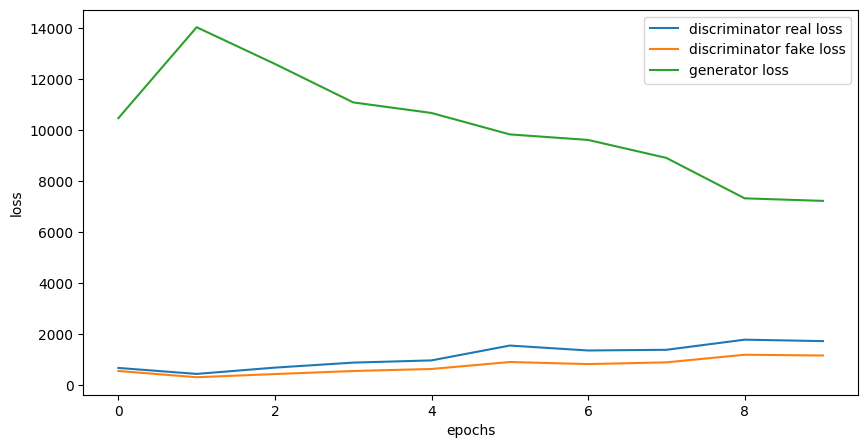

In [53]:
plt.figure(figsize=(10, 5))
plt.plot(ERRD_x, label='discriminator real loss')
plt.plot(ERRD_z, label='discriminator fake loss')
plt.plot(ERRG, label='generator loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend();

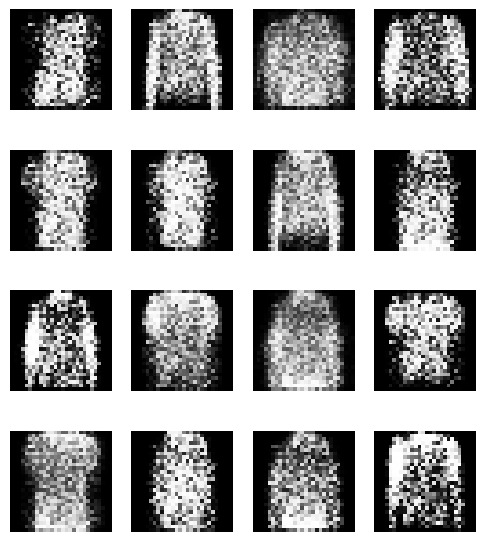

In [54]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

### Модифицируйте код ячеек ниже и реализуйте Wasserstein GAN с клиппингом весов.

In [55]:
'''
changes highlighted by comments
'''


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1))
        
            # drop sigmoid
            # nn.Sigmoid() 

    def forward(self, x):
        return self.model(x)

# added weight clipping value
clip_value = 0.01

generator = Generator()
discriminator = Discriminator()

device = "cuda" if torch.cuda.is_available() else "cpu"
generator = generator.to(device)
discriminator = discriminator.to(device)
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

# updated criterion to wasserstein loss
criterion = nn.MSELoss()

noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size, device=device))
label = Variable(torch.FloatTensor(config.batch_size, device=device))
real_label = 1

# update fake lables for discriminator
fake_label = -1

ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        discriminator.zero_grad()

        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1).to(device)

        # updated discriminator output for the real
        output_real = discriminator(input_data).view(-1)
        # updated loss function
        errD_x = -torch.mean(output_real)
        
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()

        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)

        # updated discriminator output for the fake
        output_fake = discriminator(fake.detach()).view(-1)
        # updated loss function
        errD_z = torch.mean(output_fake)

        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()

        optim_D.step()

        # added clip weights
        for param in discriminator.parameters():
            param.data.clamp_(-clip_value, clip_value)

        generator.zero_grad()
        label.data.fill_(real_label)
        output_fake = discriminator(fake).view(-1)
        errG = -torch.mean(output_fake)
        ERRG[epoch] += errG.item()
        errG.backward()

        optim_G.step()

        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(
                epoch+1, iteration+1, errD_x.item(), errD_z.item(), errG.item()))


Epoch:1 Iter: 500 errD_x: 0.02 errD_z: -0.10 errG: 0.10
Epoch:1 Iter: 1000 errD_x: -0.07 errD_z: 0.03 errG: -0.02
Epoch:1 Iter: 1500 errD_x: -0.07 errD_z: 0.06 errG: -0.05
Epoch:1 Iter: 2000 errD_x: -0.02 errD_z: -0.02 errG: 0.02
Epoch:1 Iter: 2500 errD_x: -0.09 errD_z: 0.01 errG: -0.01
Epoch:1 Iter: 3000 errD_x: -0.10 errD_z: 0.04 errG: -0.04
Epoch:1 Iter: 3500 errD_x: -0.07 errD_z: 0.05 errG: -0.05
Epoch:2 Iter: 500 errD_x: -0.03 errD_z: 0.01 errG: -0.01
Epoch:2 Iter: 1000 errD_x: -0.03 errD_z: 0.02 errG: -0.02
Epoch:2 Iter: 1500 errD_x: -0.01 errD_z: -0.01 errG: 0.01
Epoch:2 Iter: 2000 errD_x: -0.05 errD_z: 0.03 errG: -0.03
Epoch:2 Iter: 2500 errD_x: -0.06 errD_z: 0.03 errG: -0.03
Epoch:2 Iter: 3000 errD_x: -0.04 errD_z: 0.02 errG: -0.02
Epoch:2 Iter: 3500 errD_x: -0.02 errD_z: -0.01 errG: 0.01
Epoch:3 Iter: 500 errD_x: -0.02 errD_z: -0.00 errG: 0.00
Epoch:3 Iter: 1000 errD_x: -0.04 errD_z: 0.01 errG: -0.01
Epoch:3 Iter: 1500 errD_x: -0.02 errD_z: -0.00 errG: 0.00
Epoch:3 Iter: 2000

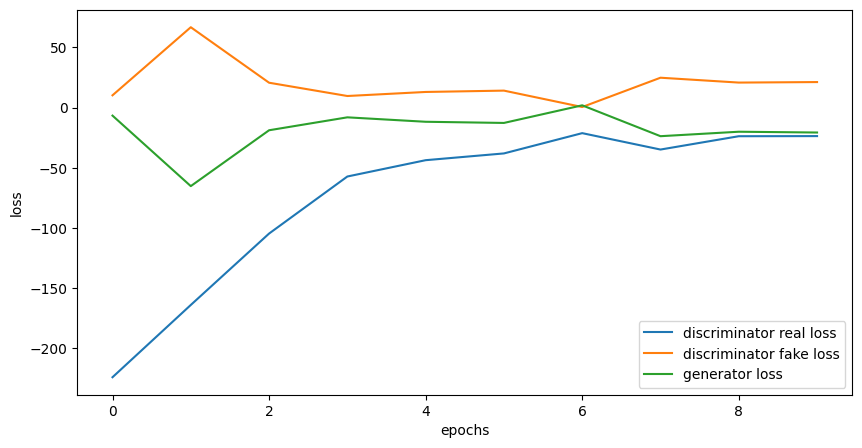

In [56]:
plt.figure(figsize=(10, 5))
plt.plot(ERRD_x, label='discriminator real loss')
plt.plot(ERRD_z, label='discriminator fake loss')
plt.plot(ERRG, label='generator loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend();

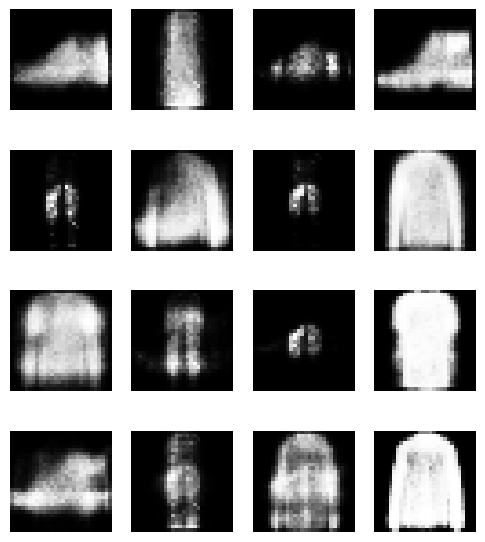

In [57]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

### Замените клиппинг весов на штраф градентов.

In [58]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1),
            nn.Sigmoid())

    def forward(self, x):
        return self.model(x)

generator = Generator()
discriminator = Discriminator()

device = "cuda" if torch.cuda.is_available() else "cpu"
generator = generator.to(device)
discriminator = discriminator.to(device)
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size, device=device))
label = Variable(torch.FloatTensor(config.batch_size, device=device))
real_label = 1
fake_label = 0

ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

# init gradient penalty weight
lambda_gp = 10

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        discriminator.zero_grad()

        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1).to(device)
        output = discriminator(input_data).view(-1)
        errD_x = criterion(output, label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()

        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach()).view(-1)
        errD_z = criterion(output, label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()

        # introduce gradient penalty
        alpha = torch.rand(input_data.size(0), 1)
        alpha = alpha.expand(input_data.size())
        alpha = alpha.to(device)

        interpolates = alpha * input_data + ((1 - alpha) * fake.detach())
        interpolates = interpolates.to(device)
        interpolates.requires_grad_(True)

        disc_interpolates = discriminator(interpolates)
        gradients = torch.autograd.grad(
            outputs=disc_interpolates, inputs=interpolates,
            grad_outputs=torch.ones(disc_interpolates.size()).to(device),
            create_graph=True, retain_graph=True, only_inputs=True
        )[0]

        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_gp
        gradient_penalty.backward()

        optim_D.step()

        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake).view(-1)
        errG = criterion(output, label)
        ERRG[epoch] += errG.item()
        errG.backward()

        optim_G.step()

        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(
                epoch+1, iteration+1, errD_x.item(), errD_z.item(), errG.item()))


Epoch:1 Iter: 500 errD_x: 0.81 errD_z: 0.58 errG: 0.84
Epoch:1 Iter: 1000 errD_x: 0.50 errD_z: 0.57 errG: 0.85
Epoch:1 Iter: 1500 errD_x: 0.68 errD_z: 0.61 errG: 0.79
Epoch:1 Iter: 2000 errD_x: 0.26 errD_z: 0.70 errG: 0.69
Epoch:1 Iter: 2500 errD_x: 0.32 errD_z: 0.67 errG: 0.71
Epoch:1 Iter: 3000 errD_x: 0.34 errD_z: 0.70 errG: 0.69
Epoch:1 Iter: 3500 errD_x: 0.38 errD_z: 0.74 errG: 0.66
Epoch:2 Iter: 500 errD_x: 0.44 errD_z: 1.16 errG: 0.41
Epoch:2 Iter: 1000 errD_x: 0.30 errD_z: 0.58 errG: 0.84
Epoch:2 Iter: 1500 errD_x: 0.37 errD_z: 0.69 errG: 0.70
Epoch:2 Iter: 2000 errD_x: 0.24 errD_z: 0.94 errG: 0.51
Epoch:2 Iter: 2500 errD_x: 0.26 errD_z: 0.70 errG: 0.69
Epoch:2 Iter: 3000 errD_x: 0.38 errD_z: 0.66 errG: 0.73
Epoch:2 Iter: 3500 errD_x: 0.58 errD_z: 0.66 errG: 0.73
Epoch:3 Iter: 500 errD_x: 0.31 errD_z: 0.97 errG: 0.53
Epoch:3 Iter: 1000 errD_x: 0.21 errD_z: 0.70 errG: 0.71
Epoch:3 Iter: 1500 errD_x: 0.22 errD_z: 0.66 errG: 0.73
Epoch:3 Iter: 2000 errD_x: 0.27 errD_z: 0.72 errG: 

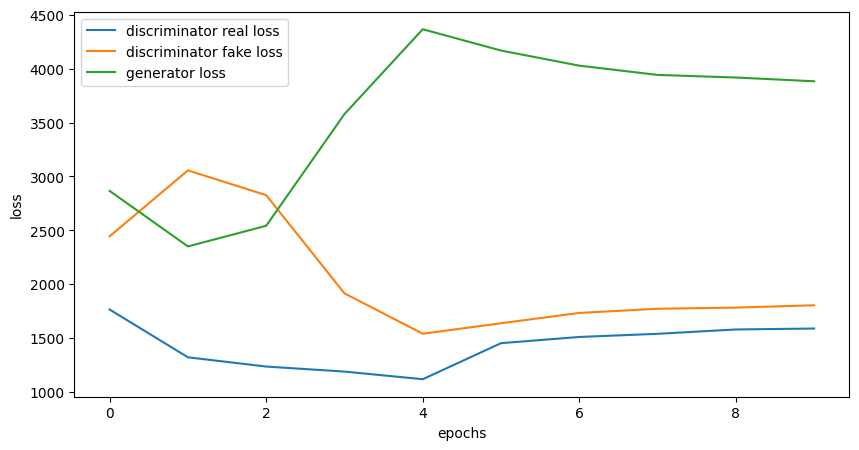

In [59]:
plt.figure(figsize=(10, 5))
plt.plot(ERRD_x, label='discriminator real loss')
plt.plot(ERRD_z, label='discriminator fake loss')
plt.plot(ERRG, label='generator loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend();

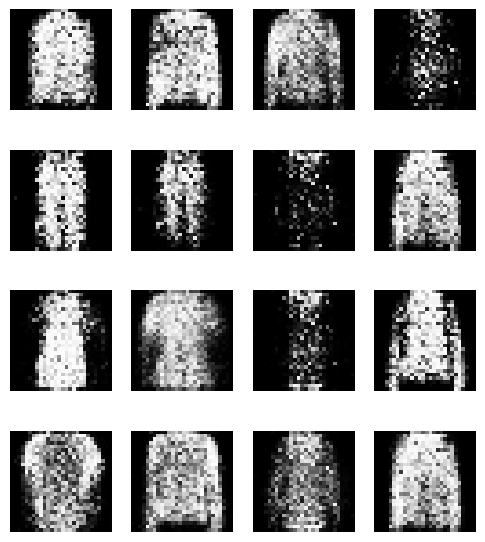

In [60]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

### Добавьте лейблы в WGAN, тем самым решая задачу условной генерации.

In [44]:
# add the number of classes for conditional generation
config.num_classes = 10  

dataloader = DataLoader(train, batch_size=config.batch_size, shuffle=True)

class Generator(nn.Module):
    # introduce no of classes parameter
    def __init__(self, num_classes):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size + num_classes, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid()
        )
        self.num_classes = num_classes

    def forward(self, x, labels):
        # concat noise and labels
        x = torch.cat([x, labels], dim=1)
        return self.model(x)

class Discriminator(nn.Module):
    # introduce no of classes parameter
    def __init__(self, num_classes):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28 + num_classes, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1)
        )
        self.num_classes = num_classes

    def forward(self, x, labels):
        # concat input and labels
        x = torch.cat([x, labels], dim=1)
        return self.model(x)

# init generator and discriminator with the number of classes
generator = Generator(config.num_classes)
discriminator = Discriminator(config.num_classes)


device = "cuda" if torch.cuda.is_available() else "cpu"
generator = generator.to(device)
discriminator = discriminator.to(device)
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.MSELoss()

noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size, device=device))
label = Variable(torch.FloatTensor(config.batch_size, device=device))
real_label = 1
fake_label = 0


ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

clip_value = 0.01

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        discriminator.zero_grad()


        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1).to(device)
        # one hot encoded labels
        labels = torch.eye(config.num_classes)[cat].to(device)
        output = discriminator(input_data, labels).view(-1)
        errD_x = -torch.mean(output)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()

        noise.data.normal_(0, 1)
        # one hot encoded labels
        fake_labels = torch.eye(config.num_classes)[torch.randint(0, config.num_classes, (config.batch_size,))].to(device)
        fake = generator(noise, fake_labels)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach(), fake_labels).view(-1)
        errD_z = torch.mean(output)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()

        optim_D.step()

        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake, fake_labels).view(-1)
        errG = -torch.mean(output)
        ERRG[epoch] += errG.item()
        errG.backward()

        optim_G.step()

        for p in discriminator.parameters():
            p.data.clamp_(-clip_value, clip_value)

        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(
                epoch+1, iteration+1, errD_x.item(), errD_z.item(), errG.item()))


Epoch:1 Iter: 500 errD_x: 0.09 errD_z: -0.16 errG: 0.16
Epoch:1 Iter: 1000 errD_x: -0.09 errD_z: -0.01 errG: 0.01
Epoch:1 Iter: 1500 errD_x: -0.11 errD_z: 0.04 errG: -0.04
Epoch:1 Iter: 2000 errD_x: -0.07 errD_z: 0.00 errG: -0.00
Epoch:1 Iter: 2500 errD_x: -0.05 errD_z: -0.03 errG: 0.04
Epoch:1 Iter: 3000 errD_x: -0.12 errD_z: 0.06 errG: -0.06
Epoch:1 Iter: 3500 errD_x: -0.10 errD_z: 0.05 errG: -0.05
Epoch:2 Iter: 500 errD_x: -0.04 errD_z: 0.00 errG: -0.00
Epoch:2 Iter: 1000 errD_x: -0.04 errD_z: 0.00 errG: -0.00
Epoch:2 Iter: 1500 errD_x: -0.04 errD_z: -0.00 errG: 0.00
Epoch:2 Iter: 2000 errD_x: -0.02 errD_z: 0.01 errG: -0.01
Epoch:2 Iter: 2500 errD_x: -0.03 errD_z: -0.01 errG: 0.01
Epoch:2 Iter: 3000 errD_x: -0.01 errD_z: -0.02 errG: 0.02
Epoch:2 Iter: 3500 errD_x: -0.04 errD_z: 0.01 errG: -0.01
Epoch:3 Iter: 500 errD_x: -0.02 errD_z: -0.01 errG: 0.01
Epoch:3 Iter: 1000 errD_x: -0.01 errD_z: -0.01 errG: 0.01
Epoch:3 Iter: 1500 errD_x: -0.03 errD_z: -0.01 errG: 0.01
Epoch:3 Iter: 2000

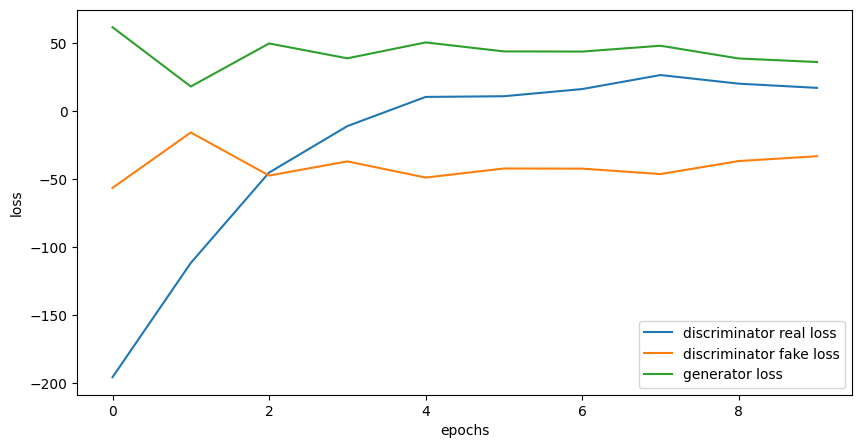

In [48]:
plt.figure(figsize=(10, 5))
plt.plot(ERRD_x, label='discriminator real loss')
plt.plot(ERRD_z, label='discriminator fake loss')
plt.plot(ERRG, label='generator loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend();

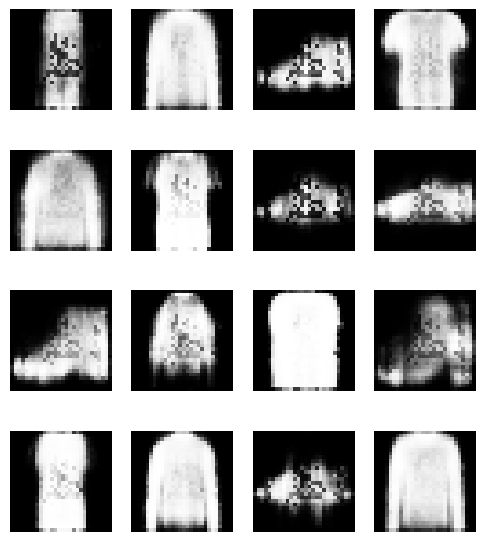

In [46]:
noise.data.normal_(0, 1)
fake_labels = torch.eye(config.num_classes)[torch.arange(config.batch_size) % config.num_classes].to(device)
fake = generator(noise, fake_labels)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().cpu().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

plt.show()